# MLP - CWE Classifier

- **Training set**: LO_SARD102 (0.75 split)
- **Test/Validation set:** LO_SARD102 (0.25 split)
- **Features**: word2vec average
- **Class imbalance processing**: Class weights

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split

/home/scheuererra68323/venv37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Load labeled dataset

In [5]:
X = numpy.stack(
    pd.read_hdf('LO_SARD102_CweCluster_word2vec.h5', key='X').word2vec_avg,
    axis=0
)
print(X.shape)

(23003, 100)


In [6]:
# CWE by Research Concepts (CWE-IDs)
researchconcepts = [284, 435, 664, 682, 691, 693, 697, 703, 707, 710]

y = numpy.array(pd.read_hdf('LO_SARD102_CweCluster_word2vec.h5', key='y'))

# delete CWE clusters w/o any examples
_y = pd.DataFrame(y, columns=researchconcepts)
_y = _y.loc[:, (_y != 0).any(axis=0)]

researchconcepts = list(_y.columns)
print(researchconcepts)

y = _y.values
print(y.shape)

[664, 682, 691, 693, 697, 707, 710]
(23003, 7)


In [7]:
indices_singleClusterFit = numpy.array(_y.T.sum().loc[_y.T.sum() == 1].index)
X_singleClusterFit = X[indices_singleClusterFit]
y_singleClusterFit = y[indices_singleClusterFit]
print(X_singleClusterFit.shape)
print(y_singleClusterFit.shape)
#y_singleClusterFit = y_singleClusterFit.argmax(axis=1)

(9859, 100)
(9859, 7)


## Create train, test, validation sets

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_singleClusterFit, y_singleClusterFit, test_size=0.2, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2


print(f"X_train: {X_train.shape}")
print(f"Y_train: {Y_train.shape}")
print()
print(f"X_val: {X_val.shape}")
print(f"Y_val: {Y_val.shape}")
print()
print(f"X_test: {X_test.shape}")
print(f"Y_test: {Y_test.shape}")

X_train: (5915, 100)
Y_train: (5915, 7)

X_val: (1972, 100)
Y_val: (1972, 7)

X_test: (1972, 100)
Y_test: (1972, 7)


In [9]:
class_weights = [( 1 / _y[_class].value_counts()[1] ) * Y_train.shape[0] / Y_train.shape[1] for _class in researchconcepts]
class_weights = {i:class_weights[i] for i in range(len(class_weights))}
class_weights

{0: 0.06280660026757841,
 1: 1.2593144560357674,
 2: 1.106020942408377,
 3: 0.07471264367816091,
 4: 7.681818181818182,
 5: 0.06342891457739079,
 6: 0.6348610067618333}

## Define and train model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 231       
Total params: 28,975
Trainable params: 28,975
Non-trainable params: 0
__________________________________________________

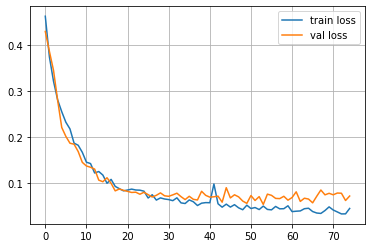

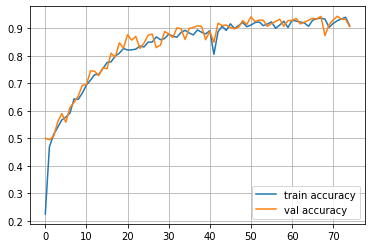

In [12]:
num_classes = Y_train.shape[1]
model = keras.Sequential(
        [
            layers.Dense(100,
                         input_dim=X_train.shape[1],
                         kernel_initializer='glorot_uniform',
                         activation=tf.nn.relu),
            
            layers.Dropout(0.1),
                        
            layers.Dense(100,
                         kernel_initializer='glorot_uniform',
                         activation=tf.nn.relu),
            
            layers.Dense(64,
                         kernel_initializer='glorot_uniform',
                         activation=tf.nn.relu),
            
            layers.Dense(32,
                         kernel_initializer='glorot_uniform',
                         activation=tf.nn.relu),
            
            layers.Dense(num_classes, 
                         kernel_initializer='glorot_uniform', 
                         activation=tf.nn.softmax),
        ]
    )
model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train,
                    batch_size=128,
                    epochs=75,
                    verbose=False,
                    validation_data=(X_val, Y_val),
                    class_weight=class_weights
                   )

plot_loss(history)
plot_accuracy(history)

## Evaluation on test

In [16]:
conf_matrix = get_confusion_matrix(model, X_test, Y_test)
print(conf_matrix)

# implementation for highlighting main diagonal taken from 
# https://stackoverflow.com/a/56916309
def highlight_diag(df):
    a = numpy.full(df.shape, '', dtype='<U24')
    numpy.fill_diagonal(a, 'background-color: yellow')
    return pd.DataFrame(a, index=df.index, columns=df.columns)

score = model.evaluate(X_test, Y_test, verbose=0)
print('\nTest loss:\t{:.6f}'.format(score[0]))
print('Test accuracy:\t{:.6f}'.format(score[1]))

pd.DataFrame(conf_matrix, columns=researchconcepts, index=researchconcepts).style.apply(highlight_diag, axis=None)

[[1311   94   20    0   10    0   19]
 [   0   87    0    0    1    0    1]
 [   1    3   93    0    4    0    0]
 [   1    0    0   10    0    0    0]
 [   0    3    0    0   20    0    0]
 [   8   12    0    1    2  128   11]
 [   0    5    0    0    2    0  125]]

Test loss:	0.292854
Test accuracy:	0.899594


,664,682,691,693,697,707,710
664,1311,94,20,0,10,0,19
682,0,87,0,0,1,0,1
691,1,3,93,0,4,0,0
693,1,0,0,10,0,0,0
697,0,3,0,0,20,0,0
707,8,12,0,1,2,128,11
710,0,5,0,0,2,0,125


In [14]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, to_categorical( numpy.argmax(model.predict(X_test), axis=1) ),
                           digits=4,
                           target_names=["CWE-"+str(cwe_id) for cwe_id in researchconcepts]) )

              precision    recall  f1-score   support

     CWE-664     0.9924    0.9017    0.9449      1454
     CWE-682     0.4265    0.9775    0.5939        89
     CWE-691     0.8230    0.9208    0.8692       101
     CWE-693     0.9091    0.9091    0.9091        11
     CWE-697     0.5128    0.8696    0.6452        23
     CWE-707     1.0000    0.7901    0.8828       162
     CWE-710     0.8013    0.9470    0.8681       132

   micro avg     0.8996    0.8996    0.8996      1972
   macro avg     0.7807    0.9022    0.8161      1972
weighted avg     0.9400    0.8996    0.9112      1972
 samples avg     0.8996    0.8996    0.8996      1972



In [15]:
savename = 'CWE_MLP_Var2_distinct_word2vec_weightedClasses.h5'
model.save(savename)
#model.load_weights(savename)